# RRT (considering holonomic constraints)
Drive link for video : https://drive.google.com/drive/folders/16qgWP3IsBTEbeLMt03lnuD8mVyKi5Gg0?usp=sharing 

We have considered a 3 wheeled omni-directional robot, with the following kinematic model
![](images/omni.png)

## Library imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import math
from enum import Enum

## Helper classes and functions

In [2]:
class Shape(Enum):
    RECT = 1
    CIRCLE = 2
    TRIANGLE = 3

class Status(Enum):
    EXTEND = 4
    TRAPPED = 5
    REACHED = 6
    
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def get_x(self):
        return self.x
    
    def get_y(self):
        return self.y

class Line:
    def __init__(self, sx, sy, ex, ey):
        self.startx = sx
        self.starty = sy
        self.endx = ex
        self.endy = ey

def ccw(A,B,C):
    return (C.y-A.y)*(B.x-A.x) > (B.y-A.y)*(C.x-A.x)

def lineseg_intersect(line1, line2):
    # https://bryceboe.com/2006/10/23/line-segment-intersection-algorithm/
    # checks if 2 line segments intersect
    
    A = Point(line1.startx,line1.starty)
    B = Point(line1.endx,line1.endy)
    C = Point(line2.startx,line2.starty)
    D = Point(line2.endx,line2.endy)
    
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def get_distance_and_angle(x1, y1, x2, y2):
    # returns distance between 2 points and slope of line connecting the two
    p1 = np.array([x1, y1])
    p2 = np.array([x2, y2])
    
    distance = np.linalg.norm(p1 - p2)
    angle = np.arctan2(y2 - y1, x2 - x1)
    
    return (distance, angle)

def get_random_pt(xmin, xmax, ymin, ymax):
    x = random.randint(xmin, xmax)
    y = random.randint(ymin, ymax)

    return (x, y)

## Class for robot
Circular robot with centre at (x,y) and radius r

In [3]:
class Robot:
    def __init__(self, x, y, r):
        self.x = x
        self.y = y
        self.r = r
        
    def get_x(self):
        return self.x
    
    def get_y(self):
        return self.y
    
    def get_r(self):
        return self.r

## Obstacle classes
Three types of obstacles considered:
### Rectangle 
- Denoted by giving top left and bottom right coordinates
- Config space is obtained at increasing each dimension by the radius of the robot in both directions.
- Collision detection with a new step of the robot (basically a line segment) is done by checking intersection of the line segment with all sides of the rectangle config space. 

### Triangle
- Considered an equilateral triangle that can face upwards or downwards by specifying a parameter.
- Denoted by giving coordinates of the centroid and length of a side.
- Config space is obtained at increasing each dimension by the radius of the robot in both directions.
- Collision detection with a new step of the robot (basically a line segment) is done by checking intersection of the line segment with all sides of the triangle config space. 

### Circle 
- Denoted by center coordinates and radius.
- Config space is denoted by increasing the radius by the radius of the robot.
- Collision detection with a new step of the robot (basically a line segment) is done by sampling points on the trajectory and checking whether each lies outside the config space of the cricle.

In [4]:
class Obstacle:
    """Super class for all obstacles"""
    def __init__(self):
        self.category = None
    
    def get_category(self):
        return self.category
    
class Rectangle(Obstacle):
    def __init__(self, xs, ys, xe, ye):
        super().__init__()
        
        self.xs = xs
        self.ys = ys
        self.xe = xe
        self.ye = ye
        self.category = Shape.RECT
    
    def _configspace(self, robot):
        robot_radius = robot.get_r()
        self.cxs = self.xs - robot_radius
        self.cys = self.ys - robot_radius
        self.cxe = self.xe + robot_radius
        self.cye = self.ye + robot_radius        
    
    def check_collision_line(self, line, robot):
        self._configspace(robot)
        
        s1 = Line(self.cxs,self.cys,self.cxe,self.cys)
        s2 = Line(self.cxs,self.cys,self.cxs,self.cye)
        s3 = Line(self.cxs,self.cye,self.cxe,self.cye)
        s4 = Line(self.cxe,self.cys,self.cxe,self.cye)
        
        collision = False
        for side in [s1,s2,s3,s4]:
            if lineseg_intersect(line, side):
                collision = True
                break
        return collision
        
    def draw(self, ax, color):
        ax.plot([self.xs, self.xs, self.xe, self.xe, self.xs], \
                [self.ys, self.ye, self.ye, self.ys, self.ys], \
                color=color)
        
class Circle(Obstacle):
    def __init__(self, x, y, r):
        super().__init__()

        self.x = x
        self.y = y
        self.r = r
        self.category = Shape.CIRCLE
        
    def _configspace(self, robot):
        self.cr = self.r + robot.get_r()
    
    def check_collision_line(self, line, robot):
        self._configspace(robot)
        # sample points on the line
        x1 = line.startx
        y1 = line.starty
        x2 = line.endx
        y2 = line.endy

        lin_x = np.linspace(x1,x2,10)
        lin_y = np.linspace(y1,y2,10)

        collision = False
        for idx in range(1, len(lin_x)):
            p,q = lin_x[idx-1], lin_y[idx-1]
            if np.linalg.norm([p-self.x,q-self.y]) <= self.cr:
                collision = True
                break
                    
        return collision
        
    def draw(self, ax, color):
        circle = plt.Circle((self.x, self.y), self.r, color=color, fill=False)
        ax.add_patch(circle)
        
class Triangle(Obstacle):
    def __init__(self, p, q, x, dir="up"):
        super().__init__()
        if dir=="up":
            self.x1, self.y1 = p - x/2 , q - x/(2*np.sqrt(3))
            self.x2, self.y2 = p + x/2 , q - x/(2*np.sqrt(3))
            self.x3, self.y3 = p , q + x/(np.sqrt(3))
        elif dir=="down":
            self.x1, self.y1 = p - x/2 , q + x/(2*np.sqrt(3))
            self.x2, self.y2 = p + x/2 , q + x/(2*np.sqrt(3))
            self.x3, self.y3 = p , q - x/(np.sqrt(3))     
        else:
            print("Invalid direction")
        self.dir = dir
        self.category = Shape.TRIANGLE
        
    def _configspace(self, robot):
        r = robot.get_r()
        
        if self.dir=="up":
            self.cx1, self.cy1 = self.x1 - np.sqrt(3)*r, self.y1 - r 
            self.cx2, self.cy2 = self.x2 + np.sqrt(3)*r, self.y2 - r 
            self.cx3, self.cy3 = self.x3, self.y3 + 2*r 
        elif self.dir=="down":
            self.cx1, self.cy1 = self.x1 - np.sqrt(3)*r, self.y1 + np.sqrt(3)*r 
            self.cx2, self.cy2 = self.x2 + np.sqrt(3)*r, self.y2 + np.sqrt(3)*r 
            self.cx3, self.cy3 = self.x3, self.y3 - 2*r 
    
    def check_collision_line(self, line, robot):
        self._configspace(robot)
        
        s1 = Line(self.cx1,self.cy1,self.cx2,self.cy2)
        s2 = Line(self.cx2,self.cy2,self.cx3,self.cy3)
        s3 = Line(self.cx1,self.cy1,self.cx3,self.cy3)

        collision = False
        for side in [s1,s2,s3]:
            if lineseg_intersect(line, side):
                collision = True
                break
        return collision
                    
        return collision

    def draw(self, ax, color):
        ax.plot([self.x1, self.x2, self.x3, self.x1], \
                [self.y1, self.y2, self.y3, self.y1], \
                color=color)

## Class Environment
- Defines the boundary, obstacles, goal.
- Handles graph plotting for all entities.
- Has a helper function that checks whether a given point is inside the boundary.
![](images/omnir.jpeg)
#### Coordinates for wheel trajectory of omni directional robot

In [5]:
class Env:
    def __init__(self, xmin, xmax, ymin, ymax, goal):
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        
        self.goal = goal
        self.robot_patch = None
        
        self.obs = []
        self.fig, self.ax = plt.subplots(1, 1, figsize=(15,15))
        
    def gen_obs(self):
        self.obs.append(Rectangle(40, 5, 50, 15))
        self.obs.append(Rectangle(60, 25, 80, 45))        
        self.obs.append(Rectangle(76, 80, 86, 95))
        self.obs.append(Circle(25, 73, 10))
        self.obs.append(Circle(45, 90, 7))
        self.obs.append(Circle(15, 30, 7))        
        self.obs.append(Triangle(60, 70, 20, "down"))
        self.obs.append(Triangle(43, 57, 10, "up"))
        self.obs.append(Triangle(80, 15, 12, "up"))      
        
    def draw_env(self):
        self.ax.plot([self.xmin, self.xmin, self.xmax, self.xmax, self.xmin],[self.ymin, self.ymax, self.ymax, self.ymin, self.ymin], 'k', lw=0.5)
        
        self.goal.draw(self.ax, 'g')
        
        for obstacle in self.obs:
            obstacle.draw(self.ax, 'r')    
    
    def refresh_plot(self):
        self.fig, self.ax = plt.subplots(1, 1, figsize=(15,15))
    
    def add_title(self, title):
        self.ax.set_title(title, loc='center', fontweight ="bold")
        
    def draw_edge(self, node1, node2, status, robot):
        x1, y1 = node1.get_pos()
        x2, y2 = node2.get_pos()

        self.ax.plot([x1, x2], [y1, y2], 'k')
        
        if status == Status.EXTEND:
            circle = plt.Circle((x2, y2), 0.2, color='yellow', fill=True)
        
        if status == Status.REACHED:
            circle = plt.Circle((x2, y2), robot.get_r(), color='blue', fill=False)

        self.ax.add_patch(circle)
        
    def draw_edge_only(self, node1, node2, color='k'):
        x1, y1 = node1.get_pos()
        x2, y2 = node2.get_pos()

        self.ax.plot([x1, x2], [y1, y2], color = color)
        
    def draw_robot(self, node, robot):
        x1, y1 = node.get_pos()

        circle = plt.Circle((x1, y1), robot.get_r(), color='blue', fill=False)
        
        if self.robot_patch:
            self.robot_patch.remove()
            
        self.robot_patch = self.ax.add_patch(circle)
        
    def draw_trajectory(self, x, y):
        self.ax.plot(x, y, color = 'green', linewidth=2)
        
    def draw_wheel_trajectory(self, x, y, robot):
        
        self.add_title('Wheel Trajectory for Omnidirectional Robot')
        x, y = np.array(x), np.array(y)
        
        self.draw_env()
        
        idx = 0
        
        r = robot.get_r()
        
        w1_x = x - r * np.cos(np.pi/6)
        w1_y = y + r * np.sin(np.pi/6)

        w2_x = x + r * np.cos(np.pi/6)
        w2_y = y + r * np.sin(np.pi/6)
        
        w3_x = x 
        w3_y = y - r 
        
        for j in range(1, len(w1_x)):
            node1 = Node(w1_x[j-1], w1_y[j-1])
            node2 = Node(w1_x[j], w1_y[j])

            self.draw_edge_only(node1, node2, color='green')

            node1 = Node(w2_x[j-1], w2_y[j-1])
            node2 = Node(w2_x[j], w2_y[j])

            self.draw_edge_only(node1, node2, color='red')

            node1 = Node(w3_x[j-1], w3_y[j-1])
            node2 = Node(w3_x[j], w3_y[j])

            self.draw_edge_only(node1, node2, color='blue')
            self.draw_robot(Node(x[j], y[j]), robot)
            
            self.fig.savefig('./holo-wheel-output/{}.png'.format(str(idx)), dpi=100)
                
            idx += 1
            
    def get_ax(self):
        return self.ax
    
    def insideEnv(self, xcheck, ycheck):
        if ycheck < self.ymin or ycheck > self.ymax or xcheck < self.xmin or xcheck > self.xmax:
            return False
        
        return True
        

## Class Node
Stores all positions encountered during the RRT formation. 
Stores the position (x,y), and all parent nodes in order to backtrack to the initial node. 

In [6]:
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y 
        
        self.parentX = []
        self.parentY = [] 
    
    # Copy all parents of parent node to current node
    def _copy_parent(self, x, y):
        self.parentX = x
        self.parentY = y
        
    # Add parent node to the list of parent nodes for the current node
    def _update_parent(self, x, y):
        self.parentX.append(x)
        self.parentY.append(y)
        
    def get_x(self):
        return self.x
    
    def get_y(self):
        return self.y
    
    def get_parent_x(self):
        return self.parentX
    
    def get_parent_y(self):
        return self.parentY
    
    def get_pos(self):
        return (self.x, self.y)

## Main RRT function

In [7]:
class RRT:
    def __init__(self, env, start, goal, stepSz, robot):
        self.env = env
        self.start = start
        self.goal = goal
        
        self.robot = robot
        
        self.stepSz = stepSz
        self.nodes = []
        
        self.foundPath = False
        
        self._gen_start_node()
        
    def _gen_start_node(self):
        '''
            Initializes the start node for RRT to start
        '''
        
        self.nodes.append(Node(self.start.get_x(), self.start.get_y()))
        self.nodes[0]._update_parent(self.start.get_x(), self.start.get_y())
    
    def _extend_graph(self, node, idx, nearestIdx, tx, ty):
        self.nodes.append(node)
        
        self.nodes[idx]._copy_parent(self.nodes[nearestIdx].get_parent_x().copy(), \
                                     self.nodes[nearestIdx].get_parent_y().copy())
        
        self.nodes[idx]._update_parent(tx, ty)
        
    def _get_nearest_node(self, x, y):
        minDist = 10e10
        nearestNodeIdx = 0
        
        for idx, node in enumerate(self.nodes): 
                        
            distance, angle = get_distance_and_angle(x, y, node.get_x(), node.get_y())
            
            if distance < minDist:
                minDist = distance
                nearestNodeIdx = idx
                
        return nearestNodeIdx
    
    def extend(self, newX, newY, nearestX, nearestY):
        
        _, theta = get_distance_and_angle(nearestX, nearestY, newX, newY)

        extendX =  nearestX + self.stepSz * np.cos(theta)
        extendY =  nearestY + self.stepSz * np.sin(theta)
        
        status = None
            
        trajectory = Line(nearestX, nearestY, extendX, extendY)
        
        if not self.env.insideEnv(extendX, extendY):
            status = Status.TRAPPED
            
        else:
            if self.goal.check_collision_line(trajectory, self.robot):
                status = Status.REACHED
                
            else:
                collided = False
                
                for obstacle in self.env.obs:
                    if obstacle.check_collision_line(trajectory, self.robot):
                        collided = True
                        break
                        
                if collided:
                    status = Status.TRAPPED
                else:
                    status = Status.EXTEND
                
        return extendX, extendY, status
    
    def engine(self):
        
        idx = 1
        
        while not self.foundPath:
            newX, newY = get_random_pt(gridStartX, gridEndX, gridStartY, gridEndY)

            nearestIdx = self._get_nearest_node(newX, newY)

            nearestX, nearestY = self.nodes[nearestIdx].get_pos()

            tx, ty, status = self.extend( newX, newY, nearestX, nearestY)

            if status == Status.EXTEND or status == Status.REACHED:
                
                nextNode = Node(tx, ty)
                self._extend_graph(nextNode, idx, nearestIdx, tx, ty)
            
                self.env.draw_edge(self.nodes[nearestIdx], nextNode, status, self.robot)
            
                self.env.fig.savefig('./holo-output/{}.png'.format(str(idx-1)), dpi=100)
                idx += 1
                
            if status == Status.REACHED:
                
                self.env.draw_trajectory(self.nodes[idx-1].get_parent_x(), self.nodes[idx-1].get_parent_y())
                
                for i in range(10):
                    self.env.fig.savefig('./holo-output/{}.png'.format(str(idx - 1 + i)), dpi=100)
                
                self.env.refresh_plot()
                self.env.gen_obs()
                
                self.env.draw_wheel_trajectory(self.nodes[idx-1].get_parent_x(), self.nodes[idx-1].get_parent_y(), self.robot)
                
                self.foundPath = True

## Running the RRT algorithm!
- We consider a grid of size (100x100), start point as (1,1) and the being a square area of size (10x10) positioned such that (75x55) is the top-left corner.
- We consider a robot of radius 2, and step size at each step to be equal to 1.

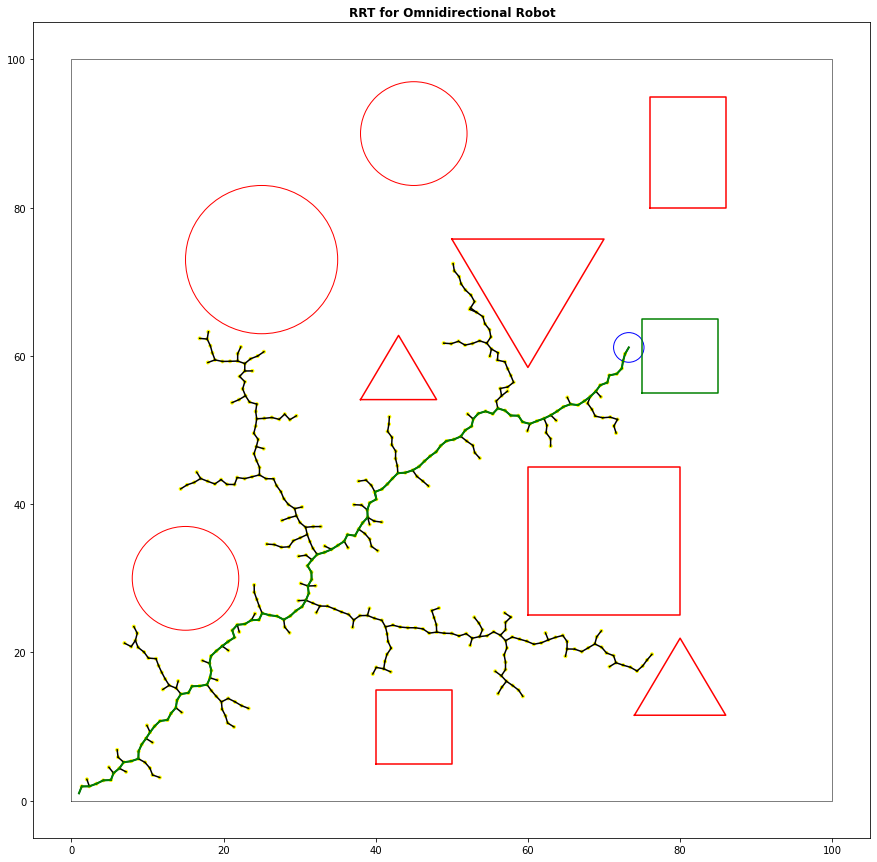

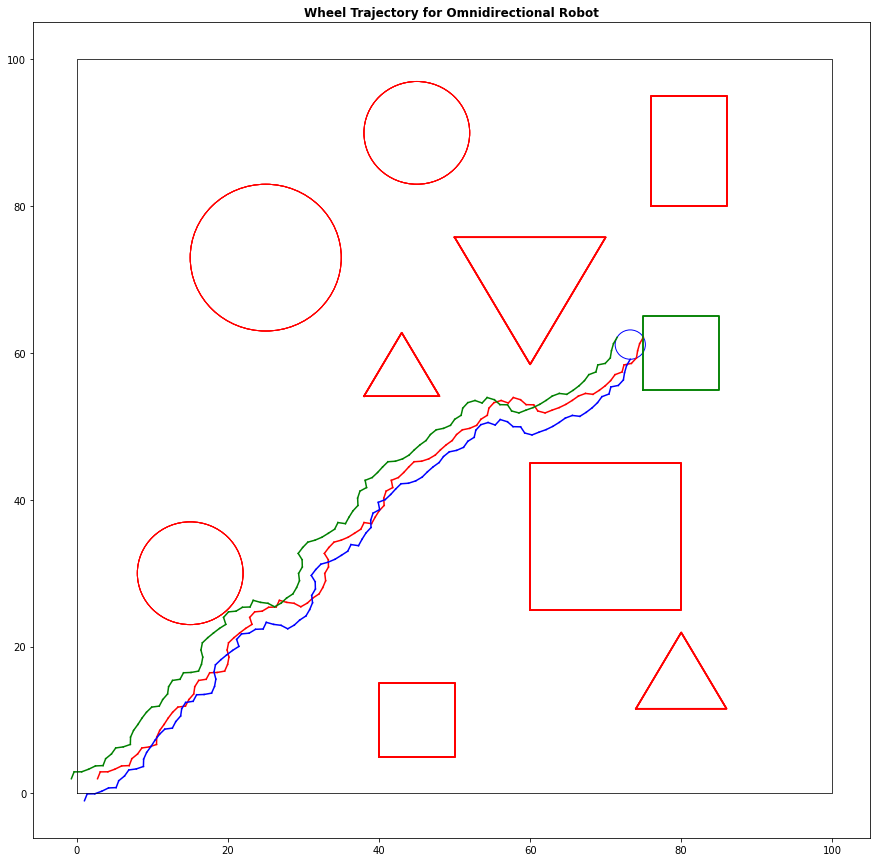

In [8]:
if __name__ == '__main__':
    
    if not os.path.exists('holo-output'):
        os.makedirs('holo-output')
    if not os.path.exists('holo-wheel-output'):
        os.makedirs('holo-wheel-output')
    
    gridStartX = 0 
    gridStartY = 0
    
    gridEndX = 100 
    gridEndY = 100
    
    stepSz = 1
    
    start = Point(1, 1)   # start   
    robotRadius = 2
    
    goal = Rectangle(75, 55, 85, 65)  # goal
    
    robot = Robot(start.get_x(), start.get_y(), robotRadius)
    
    env = Env(gridStartX, gridEndX, gridStartY, gridEndY, goal)
    env.gen_obs()
    
    env.add_title('RRT for Omnidirectional Robot')
    env.draw_env()
    
    rrt = RRT(env, start, goal, stepSz, robot)
    rrt.engine()
    
    env.draw_env()
